
# Recommendation Systems Introduction

* Recommendation systems are one on the most valuable applicatins of Machine Learning.
* Amazon attributes 20% their 221.60 billion dollars of their yearly revenues to recommendation.
* Recommendation systems can use explicit and implict data.
    - A user rating for a product or movie is explicit.
    - Buying/watched history for a user is implicit.
* Implicit data is already personalised.
* Explicit data often needs to be renomalised across users -- For example, users may rate movies differently.
* One simple approach to the problem is item-based collaborative filtering.
* You can also go in the opposite direction and perform user-based collaborative filtering.

![alt text](RecMatrix.png "The Recommender Matrix")



# Exploring the dataset

In [1]:
# First lets just see an example algorithm run on movielens.

import os
import csv
import sys
import re
from surprise import Dataset
from surprise import Reader
from collections import defaultdict
import numpy as np
from surprise import SVD
import pandas as pd

ratingsFile = 'ratings.csv'
moviesFile = 'movies.csv'

rdf = pd.read_csv(ratingsFile,header=0)
print('Head of ratings csv')
rdf.head()

Head of ratings csv


userId  movieId  rating   timestamp
0       1       31     2.5  1260759144
1       1     1029     3.0  1260759179
2       1     1061     3.0  1260759182
3       1     1129     2.0  1260759185
4       1     1172     4.0  1260759205

In [2]:
mdf = pd.read_csv(moviesFile,header=0)
print('Head of movies csv')
mdf.head()

Head of movies csv


movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

In [3]:
dflinks = pd.read_csv("links.csv")
dftags = pd.read_csv("tags.csv")
#take a look at the training data
dflinks.head()

movieId  imdbId   tmdbId
0        1  114709    862.0
1        2  113497   8844.0
2        3  113228  15602.0
3        4  114885  31357.0
4        5  113041  11862.0

In [4]:
dftags.head()

userId  movieId                      tag   timestamp
0      15      339  sandra 'boring' bullock  1138537770
1      15     1955                  dentist  1193435061
2      15     7478                 Cambodia  1170560997
3      15    32892                  Russian  1170626366
4      15    34162              forgettable  1141391765

In [5]:
#get a list of the features within the dataset
print("Movie : ", mdf.columns,end="\n\n")
print("Rating : ", rdf.columns,end="\n\n")
print("Links : ", dflinks.columns,end="\n\n")
print("Tags : ", dftags.columns,end="\n\n")

mdf.info()
rdf.info()
dftags.info()

Movie :  Index(['movieId', 'title', 'genres'], dtype='object')

Rating :  Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

Links :  Index(['movieId', 'imdbId', 'tmdbId'], dtype='object')

Tags :  Index(['userId', 'movieId', 'tag', 'timestamp'], dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9125 non-null   int64 
 1   title    9125 non-null   object
 2   genres   9125 non-null   object
dtypes: int64(1), object(2)
memory usage: 214.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1),

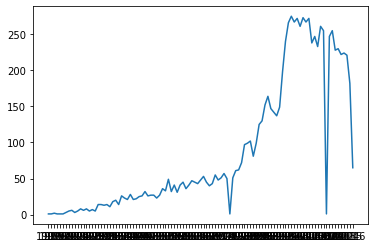

Max No.of Movies Relesed = 275
Year = 1996


count    105.000000
mean      86.866667
std       92.458522
min        1.000000
25%       20.000000
50%       45.000000
75%      147.000000
max      275.000000
Name: title, dtype: float64

In [6]:
#visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Extracting the year from the Title
mdf['Year'] = mdf['title'].str.extract('.*\((.*)\).*',expand = False)

#Ploting a Graph with No.of Movies each Year corresponding to its Year
plt.plot(mdf.groupby('Year').title.count())
plt.show()
a=mdf.groupby('Year').title.count()
print('Max No.of Movies Relesed =',a.max())
for i in a.index:
    if a[i] == a.max():
        print('Year =',i)
a.describe()

In [7]:
# Seperate the Geners Column and Encoding them with One-Hot-Encoding Method.
genres=[]
for i in range(len(mdf.genres)):
    for x in mdf.genres[i].split('|'):
        if x not in genres:
            genres.append(x)  

len(genres)
for x in genres:
    mdf[x] = 0
for i in range(len(mdf.genres)):
    for x in mdf.genres[i].split('|'):
        mdf[x][i]=1
mdf

movieId                                              title  \
0           1                                   Toy Story (1995)   
1           2                                     Jumanji (1995)   
2           3                            Grumpier Old Men (1995)   
3           4                           Waiting to Exhale (1995)   
4           5                 Father of the Bride Part II (1995)   
...       ...                                                ...   
9120   162672                                Mohenjo Daro (2016)   
9121   163056                               Shin Godzilla (2016)   
9122   163949  The Beatles: Eight Days a Week - The Touring Y...   
9123   164977                           The Gay Desperado (1936)   
9124   164979                              Women of '69, Unboxed   

                                           genres  Year  Adventure  Animation  \
0     Adventure|Animation|Children|Comedy|Fantasy  1995          1          1   
1                      Adventure|Children|Fantasy  1995          1          0   
2                                  Comedy|Romance  1995          0          0   
3                            Comedy|Drama|Romance  1995          0          0   
4                                          Comedy  1995          0          0   
...                                           ...   ...        ...        ...   
9120                      Adventure|Drama|Romance  2016          1          0   
9121              Action|Adventure|Fantasy|Sci-Fi  2016          1          0   
9122                                  Documentary  2016          0          0   
9123                                       Comedy  1936          0          0   
9124                                  Documentary   NaN          0          0   

      Children  Comedy  Fantasy  Romance  ...  Horror  Mystery  Sci-Fi  \
0            1       1        1        0  ...       0        0       0   
1            1       0        1        0  ...       0        0       0   
2            0       1        0        1  ...       0        0       0   
3            0       1        0        1  ...       0        0       0   
4            0       1        0        0  ...       0        0       0   
...        ...     ...      ...      ...  ...     ...      ...     ...   
9120         0       0        0        1  ...       0        0       0   
9121         0       0        1        0  ...       0        0       1   
9122         0       0        0        0  ...       0        0       0   
9123         0       1        0        0  ...       0        0       0   
9124         0       0        0        0  ...       0        0       0   

      Documentary  IMAX  War  Musical  Western  Film-Noir  (no genres listed)  
0               0     0    0        0        0          0                   0  
1               0     0    0        0        0          0                   0  
2               0     0    0        0        0          0                   0  
3               0     0    0        0        0          0                   0  
4               0     0    0        0        0          0                   0  
...           ...   ...  ...      ...      ...        ...                 ...  
9120            0     0    0        0        0          0                   0  
9121            0     0    0        0        0          0                   0  
9122            1     0    0        0        0          0                   0  
9123            0     0    0        0        0          0                   0  
9124            1     0    0        0        0          0                   0  

[9125 rows x 24 columns]

In [8]:
mdf.drop(columns='genres',inplace=True)
mdf.sort_index(inplace=True)

Animation    				447
Children    				583
Comedy    				3315
Fantasy    				654
Romance    				1545
Drama    				4365
Action    				1545
Crime    				1100
Thriller    				1729
Horror    				877
Mystery    				543
Sci-Fi    				792
Documentary    				495
IMAX    				153
War    				367
Musical    				394
Western    				168
Film-Noir    				133
(no genres listed)    				18


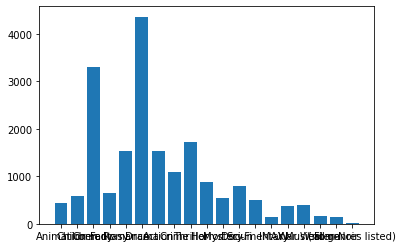

In [9]:
x={}
for i in mdf.columns[4:23]:
    x[i]=mdf[i].value_counts()[1]
    print("{}    \t\t\t\t{}".format(i,x[i]))

plt.bar(height=x.values(),x=x.keys())
plt.show()

In [10]:
#Add a Column `rating` in movie DF and assign them with the Mean Movie Rating for that Movie.
x=rdf.groupby('movieId').rating.mean()
mdf = pd.merge(mdf,x,how='outer',on='movieId')
mdf['rating'].fillna('0',inplace=True)
# Now Lets group all the ratings with respect to movieId and count the no of Users
x = rdf.groupby('movieId',as_index=False).userId.count()
x.sort_values('userId',ascending=False,inplace=True)
y = pd.merge(mdf,x,how='outer',on='movieId')

y.drop(columns=[i for i in mdf.columns[2:23]],inplace=True)

y.sort_values(['userId','rating'],ascending=False)

movieId                                      title    rating  userId
321       356                        Forrest Gump (1994)  4.054252   341.0
266       296                        Pulp Fiction (1994)  4.256173   324.0
284       318           Shawshank Redemption, The (1994)  4.487138   311.0
525       593           Silence of the Lambs, The (1991)  4.138158   304.0
232       260  Star Wars: Episode IV - A New Hope (1977)  4.221649   291.0
...       ...                                        ...       ...     ...
9112   161336          Author: The JT LeRoy Story (2016)         0     NaN
9113   161582                  Hell or High Water (2016)         0     NaN
9121   163056                       Shin Godzilla (2016)         0     NaN
9123   164977                   The Gay Desperado (1936)         0     NaN
9124   164979                      Women of '69, Unboxed         0     NaN

[9125 rows x 4 columns]

In [11]:
#Find the user with highest no.of. movie ratings and that users mean rating. 
x = rdf.groupby('userId',as_index=False).movieId.count()
y = rdf.groupby('userId',as_index=False).rating.mean()
x = pd.merge(x,y,how='outer',on='userId')
x.describe()

userId      movieId      rating
count  671.000000   671.000000  671.000000
mean   336.000000   149.037258    3.657587
std    193.845299   231.226948    0.471339
min      1.000000    20.000000    1.333333
25%    168.500000    37.000000    3.396193
50%    336.000000    71.000000    3.675000
75%    503.500000   161.000000    3.984026
max    671.000000  2391.000000    4.948718

In [12]:
# From below we found that userId - 546 has given the Highest no.of Ratings with 
# 2391 and an Average of 3.37 Stars followed by userId-564 with 1868 Ratings and 
# an Average of 3.55 Stars and so on …
x.sort_values('movieId',ascending=False)

userId  movieId    rating
546     547     2391  3.366792
563     564     1868  3.552463
623     624     1735  2.894236
14       15     1700  2.621765
72       73     1610  3.374224
..      ...      ...       ...
295     296       20  3.975000
288     289       20  3.675000
248     249       20  3.600000
220     221       20  2.775000
0         1       20  2.550000

[671 rows x 3 columns]

# Using the Surprise recommender library api

In [13]:
# Load and Procress all of the data using Surprise library tools.

reader = Reader(line_format='user item rating timestamp', sep=',', skip_lines=1)
ratingsDataset = Dataset.load_from_file(ratingsFile, reader=reader)

movieID_to_name = {}
name_to_movieID = {}

ratings = defaultdict(int)
rankings = defaultdict(int)
genres = defaultdict(list)

genreIDs = {}
maxGenreID = 0
rank = 1

with open(moviesFile, newline='') as csvfile:
    movieReader = csv.reader(csvfile)
    next(movieReader)  #Skip header line
    for row in movieReader:
        movieID = int(row[0])
        movieName = row[1]
        movieID_to_name[movieID] = movieName
        name_to_movieID[movieName] = movieID

with open(ratingsFile, newline='') as csvfile:
    ratingReader = csv.reader(csvfile)
    next(ratingReader)
    for row in ratingReader:
        movieID = int(row[1])
        ratings[movieID] += 1
    
with open(moviesFile, newline='') as csvfile:
    movieReader = csv.reader(csvfile)
    next(movieReader)  #Skip header line
    for row in movieReader:
        movieID = int(row[0])
        genreList = row[2].split('|')
        genreIDList = []
        for genre in genreList:
            if genre in genreIDs:
                genreID = genreIDs[genre]
            else:
                genreID = maxGenreID
                genreIDs[genre] = genreID
                maxGenreID += 1
            genreIDList.append(genreID)
        genres[movieID] = genreIDList

# Build rankings dictionary.
for movieID, ratingCount in sorted(ratings.items(), key=lambda x: x[1], reverse=True):
    rankings[movieID] = rank
    rank += 1

# Convert integer-encoded genre lists to bitfields that we can treat as vectors
for (movieID, genreIDList) in genres.items():
    bitfield = [0] * maxGenreID
    for genreID in genreIDList:
         bitfield[genreID] = 1
    genres[movieID] = bitfield
            
def getUserRatings(user):
    userRatings = []
    hitUser = False
    with open(ratingsFile, newline='') as csvfile:
        ratingReader = csv.reader(csvfile)
        next(ratingReader)
        for row in ratingReader:
            userID = int(row[0])
            if (user == userID):
                movieID = int(row[1])
                rating = float(row[2])
                userRatings.append((movieID, rating))
                hitUser = True
            if (hitUser and (user != userID)):
                break
    return userRatings
        
def BuildAntiTestSetForUser(testSubject, trainset):
    fill = trainset.global_mean
    anti_testset = []
    u = trainset.to_inner_uid(str(testSubject))
    user_items = set([j for (j, _) in trainset.ur[u]])
    anti_testset += [(trainset.to_raw_uid(u), trainset.to_raw_iid(i), fill) for
                             i in trainset.all_items() if
                             i not in user_items]
    return anti_testset

def getMovieName(movieID):
    if movieID in movieID_to_name:
        return movieID_to_name[movieID]
    else:
        return ""
        
def getMovieID(movieName):
    if movieName in name_to_movieID:
        return name_to_movieID[movieName]
    else:
        return 0  


# Simple Collaborative Filtering
![alt text](collabf.png "Simple Collaborative filtering")

In [14]:
# Simple Item Based Collaborative Filtering -- the algorithm that Amazon made famous in 2003.

from surprise import KNNBasic
import heapq
from collections import defaultdict
from operator import itemgetter

testSubject = '85'
k = 10
trainSet = ratingsDataset.build_full_trainset()
sim_options = {'name': 'cosine','user_based': False}
model = KNNBasic(sim_options=sim_options)
model.fit(trainSet)
simsMatrix = model.compute_similarities()
testUserInnerID = trainSet.to_inner_uid(testSubject)
# Get the top K items we rated
testUserRatings = trainSet.ur[testUserInnerID]
kNeighbors = heapq.nlargest(k, testUserRatings, key=lambda t: t[1])
# Get similar items to stuff we liked (weighted by rating)
candidates = defaultdict(float)

for itemID, rating in kNeighbors:
    similarityRow = simsMatrix[itemID]
    for innerID, score in enumerate(similarityRow):
        candidates[innerID] += score * (rating / 5.0)

#  Build a dictionary of stuff the user has already seen
watched = {}

for itemID, rating in trainSet.ur[testUserInnerID]:
    watched[itemID] = 1

# Get top-rated items from similar users:
pos = 0

for itemID, ratingSum in sorted(candidates.items(), key=itemgetter(1), reverse=True):
    if not itemID in watched:
        movieID = trainSet.to_raw_iid(itemID)
        print(getMovieName(int(movieID)), ratingSum)
        pos += 1
        if (pos > 10):
            break

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
James Dean Story, The (1957) 10.0
Get Real (1998) 9.987241120712646
Kiss of Death (1995) 9.966881877751941
Set It Off (1996) 9.963732215657119
How Green Was My Valley (1941) 9.943984081065269
Amos & Andrew (1993) 9.93973694500253
My Crazy Life (Mi vida loca) (1993) 9.938290487546041
Grace of My Heart (1996) 9.926255896645218
Fanny and Alexander (Fanny och Alexander) (1982) 9.925699671455906
Wild Reeds (Les roseaux sauvages) (1994) 9.916226404418774
Edge of Seventeen (1998) 9.913028764691676


In [15]:
# Simple User-based collaborative filtering
from surprise import KNNBasic
import heapq
from collections import defaultdict
from operator import itemgetter

testSubject = '85'
k = 10
trainSet = ratingsDataset.build_full_trainset()
sim_options = {'name': 'cosine','user_based': True}
model = KNNBasic(sim_options=sim_options)
model.fit(trainSet)
simsMatrix = model.compute_similarities()
# Get top N similar users to our test subject
# (Alternate approach would be to select users up to some similarity threshold - try it!)
testUserInnerID = trainSet.to_inner_uid(testSubject)
similarityRow = simsMatrix[testUserInnerID]
similarUsers = []
for innerID, score in enumerate(similarityRow):
    if (innerID != testUserInnerID):
        similarUsers.append( (innerID, score) )

kNeighbors = heapq.nlargest(k, similarUsers, key=lambda t: t[1])
# Get the stuff they rated, and add up ratings for each item, weighted by user similarity
candidates = defaultdict(float)
for similarUser in kNeighbors:
    innerID = similarUser[0]
    userSimilarityScore = similarUser[1]
    theirRatings = trainSet.ur[innerID]
    for rating in theirRatings:
        candidates[rating[0]] += (rating[1] / 5.0) * userSimilarityScore

# Build a dictionary of stuff the user has already seen
watched = {}
for itemID, rating in trainSet.ur[testUserInnerID]:
    watched[itemID] = 1

# Get top-rated items from similar users:
pos = 0
for itemID, ratingSum in sorted(candidates.items(), key=itemgetter(1), reverse=True):
    if not itemID in watched:
        movieID = trainSet.to_raw_iid(itemID)
        print(getMovieName(int(movieID)), ratingSum)
        pos += 1
        if (pos > 10):
            break


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Inception (2010) 3.3
Star Wars: Episode V - The Empire Strikes Back (1980) 2.4
Bourne Identity, The (1988) 2.0
Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000) 2.0
Dark Knight, The (2008) 2.0
Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966) 1.9
Departed, The (2006) 1.9
Dark Knight Rises, The (2012) 1.9
Back to the Future (1985) 1.9
Gravity (2013) 1.8
Fight Club (1999) 1.8


# Evaluation of Recommendations

In [16]:
# Helper class to evalute Recommendation Systems Quality by multiple poplular measures.
# As you can see there is no shortage on ways that quality is measured in this field.
import itertools
from surprise import accuracy
from collections import defaultdict

class RecommenderMetrics:

    # Mean Average Error
    def MAE(predictions):
        return accuracy.mae(predictions, verbose=False)
    
    # Root Mean Squared error
    def RMSE(predictions):
        return accuracy.rmse(predictions, verbose=False)

    # Not a metric. It s the top-N predictions for an algorithm.
    def GetTopN(predictions, n=10, minimumRating=4.0):
        topN = defaultdict(list)
        for userID, movieID, actualRating, estimatedRating, _ in predictions:
            if (estimatedRating >= minimumRating):
                topN[int(userID)].append((int(movieID), estimatedRating))
        for userID, ratings in topN.items():
            ratings.sort(key=lambda x: x[1], reverse=True)
            topN[int(userID)] = ratings[:n]
        return topN

    # How good is this top-10 list?
    # - Find all items in this user’s history in the training data.
    # - Intentionally remove one of these items ( Leave-One-Out cross-validation).
    # - Use all other items to feed the recommender and ask for top 10 recommendations.
    # - If the removed item appear in the top 10 recommendations, it is a hit. If not, it’s not a hit.
    def HitRate(topNPredicted, leftOutPredictions):
        hits = 0
        total = 0
        # For each left-out rating
        for leftOut in leftOutPredictions:
            userID = leftOut[0]
            leftOutMovieID = leftOut[1]
            # Is it in the predicted top 10 for this user?
            hit = False
            for movieID, predictedRating in topNPredicted[int(userID)]:
                if (int(leftOutMovieID) == int(movieID)):
                    hit = True
                    break
            if (hit) :
                hits += 1
            total += 1
        # Compute overall precision
        return hits/total
    
    # Normally you set the rating cutoff. When you do the quantifies how good
    # the results are based on rating preference.
    def CumulativeHitRate(topNPredicted, leftOutPredictions, ratingCutoff=0):
        hits = 0
        total = 0
        # For each left-out rating
        for userID, leftOutMovieID, actualRating, estimatedRating, _ in leftOutPredictions:
            # Only look at ability to recommend things the users actually liked...
            if (actualRating >= ratingCutoff):
                # Is it in the predicted top 10 for this user?
                hit = False
                for movieID, predictedRating in topNPredicted[int(userID)]:
                    if (int(leftOutMovieID) == movieID):
                        hit = True
                        break
                if (hit) :
                    hits += 1
                total += 1
        # Compute overall precision
        return hits/total
    
    # Determine the hit rat by each rating grade.
    def RatingHitRate(topNPredicted, leftOutPredictions):
        hits = defaultdict(float)
        total = defaultdict(float)
        # For each left-out rating
        for userID, leftOutMovieID, actualRating, estimatedRating, _ in leftOutPredictions:
            # Is it in the predicted top N for this user?
            hit = False
            for movieID, predictedRating in topNPredicted[int(userID)]:
                if (int(leftOutMovieID) == movieID):
                    hit = True
                    break
            if (hit) :
                hits[actualRating] += 1
            total[actualRating] += 1
        # Compute overall precision
        for rating in sorted(hits.keys()):
            print (rating, hits[rating] / total[rating])
    
    # Some argue that this is one of the best ways to evaluate a recommender system.
    # It is similar to reciprical rank -- the average of the first relevant hit for each prediction.
    def AverageReciprocalHitRank(topNPredicted, leftOutPredictions):
        summation = 0
        total = 0
        # For each left-out rating
        for userID, leftOutMovieID, actualRating, estimatedRating, _ in leftOutPredictions:
            # Is it in the predicted top N for this user?
            hitRank = 0
            rank = 0
            for movieID, predictedRating in topNPredicted[int(userID)]:
                rank = rank + 1
                if (int(leftOutMovieID) == movieID):
                    hitRank = rank
                    break
            if (hitRank > 0) :
                summation += 1.0 / hitRank
            total += 1
        return summation / total

    # What percentage of users have at least one "good" recommendation?
    def UserCoverage(topNPredicted, numUsers, ratingThreshold=0):
        hits = 0
        for userID in topNPredicted.keys():
            hit = False
            for movieID, predictedRating in topNPredicted[userID]:
                if (predictedRating >= ratingThreshold):
                    hit = True
                    break
            if (hit):
                hits += 1
        return hits / numUsers

    # A somewhat infamous issue in recommendations is that over time, they do a poor
    # job of recommending "different" things than what you have already selected.
    def Diversity(topNPredicted, simsAlgo):
        n = 0
        total = 0
        simsMatrix = simsAlgo.compute_similarities()
        for userID in topNPredicted.keys():
            pairs = itertools.combinations(topNPredicted[userID], 2)
            for pair in pairs:
                movie1 = pair[0][0]
                movie2 = pair[1][0]
                innerID1 = simsAlgo.trainset.to_inner_iid(str(movie1))
                innerID2 = simsAlgo.trainset.to_inner_iid(str(movie2))
                similarity = simsMatrix[innerID1][innerID2]
                total += similarity
                n += 1
        S = total / n
        return (1-S)

    # Closely related to the diversity problem -- does the algorithm recommend really
    # "differet" things or not? For example if you watch a bunch of horror movies, will
    # you only see other horror movies in the list?
    def Novelty(topNPredicted, rankings):
        n = 0
        total = 0
        for userID in topNPredicted.keys():
            for rating in topNPredicted[userID]:
                movieID = rating[0]
                rank = rankings[movieID]
                total += rank
                n += 1
        return total / n

In [17]:
# Helper Class for Evaluation runs
from surprise.model_selection import train_test_split
from surprise.model_selection import LeaveOneOut
from surprise import KNNBaseline

class EvaluationData:
    def __init__(self, data, popularityRankings):
        self.rankings = popularityRankings
        #Build a full training set for evaluating overall properties
        self.fullTrainSet = data.build_full_trainset()
        self.fullAntiTestSet = self.fullTrainSet.build_anti_testset()
        #Build a 75/25 train/test split for measuring accuracy
        self.trainSet, self.testSet = train_test_split(data, test_size=.25, random_state=1)
        #Build a "leave one out" train/test split for evaluating top-N recommenders
        #And build an anti-test-set for building predictions
        LOOCV = LeaveOneOut(n_splits=1, random_state=1)
        for train, test in LOOCV.split(data):
            self.LOOCVTrain = train
            self.LOOCVTest = test
        self.LOOCVAntiTestSet = self.LOOCVTrain.build_anti_testset()
        #Compute similarty matrix between items so we can measure diversity
        sim_options = {'name': 'cosine', 'user_based': False}
        self.simsAlgo = KNNBaseline(sim_options=sim_options)
        self.simsAlgo.fit(self.fullTrainSet)

    def GetFullTrainSet(self):
        return self.fullTrainSet

    def GetFullAntiTestSet(self):
        return self.fullAntiTestSet
    
    def GetAntiTestSetForUser(self, testSubject):
        trainset = self.fullTrainSet
        fill = trainset.global_mean
        anti_testset = []
        u = trainset.to_inner_uid(str(testSubject))
        user_items = set([j for (j, _) in trainset.ur[u]])
        anti_testset += [(trainset.to_raw_uid(u), trainset.to_raw_iid(i), fill) for
                                 i in trainset.all_items() if
                                 i not in user_items]
        return anti_testset

    def GetTrainSet(self):
        return self.trainSet

    def GetTestSet(self):
        return self.testSet

    def GetLOOCVTrainSet(self):
        return self.LOOCVTrain

    def GetLOOCVTestSet(self):
        return self.LOOCVTest

    def GetLOOCVAntiTestSet(self):
        return self.LOOCVAntiTestSet

    def GetSimilarities(self):
        return self.simsAlgo
    
    def GetPopularityRankings(self):
        return self.rankings

In [18]:
# Finally a helper class that combines the two above into a single comprehensive tool to measure qualityand
# compare algortihm performance.
class EvaluationAlgorithm:

    def __init__(self, algorithm, name):
        self.algorithm = algorithm
        self.name = name

    def Evaluate(self, evaluationData, doTopN, n=10, verbose=True):
        metrics = {}
        # Compute accuracy
        if (verbose):
            print("Evaluating accuracy...")
        self.algorithm.fit(evaluationData.GetTrainSet())
        predictions = self.algorithm.test(evaluationData.GetTestSet())
        metrics["RMSE"] = RecommenderMetrics.RMSE(predictions)
        metrics["MAE"] = RecommenderMetrics.MAE(predictions)
        if (doTopN):
            # Evaluate top-10 with Leave One Out testing
            if (verbose):
                print("Evaluating top-N with leave-one-out...")
            self.algorithm.fit(evaluationData.GetLOOCVTrainSet())
            leftOutPredictions = self.algorithm.test(evaluationData.GetLOOCVTestSet())
            # Build predictions for all ratings not in the training set
            allPredictions = self.algorithm.test(evaluationData.GetLOOCVAntiTestSet())
            # Compute top 10 recs for each user
            topNPredicted = RecommenderMetrics.GetTopN(allPredictions, n)
            if (verbose):
                print("Computing hit-rate and rank metrics...")
            # See how often we recommended a movie the user actually rated
            metrics["HR"] = RecommenderMetrics.HitRate(topNPredicted, leftOutPredictions)
                        # See how often we recommended a movie the user actually liked
            metrics["cHR"] = RecommenderMetrics.CumulativeHitRate(topNPredicted, leftOutPredictions)
            # Compute ARHR
            metrics["ARHR"] = RecommenderMetrics.AverageReciprocalHitRank(topNPredicted, leftOutPredictions)
            #Evaluate properties of recommendations on full training set
            if (verbose):
                print("Computing recommendations with full data set...")
            self.algorithm.fit(evaluationData.GetFullTrainSet())
            allPredictions = self.algorithm.test(evaluationData.GetFullAntiTestSet())
            topNPredicted = RecommenderMetrics.GetTopN(allPredictions, n)
            if (verbose):
                print("Analyzing coverage, diversity, and novelty...")
            # Print user coverage with a minimum predicted rating of 4.0:
            metrics["Coverage"] = RecommenderMetrics.UserCoverage(  topNPredicted,
                                                                   evaluationData.GetFullTrainSet().n_users,
                                                                   ratingThreshold=4.0)
            # Measure diversity of recommendations:
            metrics["Diversity"] = RecommenderMetrics.Diversity(topNPredicted, evaluationData.GetSimilarities())
            # Measure novelty (average popularity rank of recommendations):
            metrics["Novelty"] = RecommenderMetrics.Novelty(topNPredicted,
                                                            evaluationData.GetPopularityRankings())
        if (verbose):
            print("Analysis complete.")
        return metrics
    
    def GetName(self):
        return self.name

    def GetAlgorithm(self):
        return self.algorithm



In [19]:
class Evaluator:
    algorithms = []

    def __init__(self, dataset, rankings):
        ed = EvaluationData(dataset, rankings)
        self.dataset = ed

    def AddAlgorithm(self, algorithm, name):
        alg = EvaluationAlgorithm(algorithm, name)
        self.algorithms.append(alg)

    def Evaluate(self, doTopN):
        results = {}
        for algorithm in self.algorithms:
            print("Evaluating ", algorithm.GetName(), "...")
            results[algorithm.GetName()] = algorithm.Evaluate(self.dataset, doTopN)
        # Print results
        print("\n")
        if (doTopN):
            print("{:<10} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10}".format(
                    "Algorithm", "RMSE", "MAE", "HR", "cHR", "ARHR", "Coverage", "Diversity", "Novelty"))
            for (name, metrics) in results.items():
                print("{:<10} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f}".format(
                        name, metrics["RMSE"], metrics["MAE"], metrics["HR"], metrics["cHR"], metrics["ARHR"],
                        metrics["Coverage"], metrics["Diversity"], metrics["Novelty"]))
        else:
            print("{:<10} {:<10} {:<10}".format("Algorithm", "RMSE", "MAE"))
            for (name, metrics) in results.items():
                print("{:<10} {:<10.4f} {:<10.4f}".format(name, metrics["RMSE"], metrics["MAE"]))
        print("\nLegend:\n")
        print("RMSE:      Root Mean Squared Error. Lower values mean better accuracy.")
        print("MAE:       Mean Absolute Error. Lower values mean better accuracy.")
        if (doTopN):
            print("HR:        Hit Rate; how often we are able to recommend a left-out rating. Higher is better.")
            print("cHR:       Cumulative Hit Rate; hit rate, confined to ratings above a certain threshold. Higher is better.")
            print("ARHR:      Average Reciprocal Hit Rank - Hit rate that takes the ranking into account. Higher is better." )
            print("Coverage:  Ratio of users for whom recommendations above a certain threshold exist. Higher is better.")
            print("Diversity: 1-S, where S is the average similarity score between every possible pair of recommendations")
            print("           for a given user. Higher means more diverse.")
            print("Novelty:   Average popularity rank of recommended items. Higher means more novel.")

    def SampleTopNRecs(self, testSubject=85, k=10):
        for algo in self.algorithms:
            print("\nUsing recommendation algorithm", algo.GetName())
            print("\nBuilding recommendation model...")
            trainSet = self.dataset.GetFullTrainSet()
            algo.GetAlgorithm().fit(trainSet)
            print("Computing recommendations...")
            testSet = self.dataset.GetAntiTestSetForUser(testSubject)
            predictions = algo.GetAlgorithm().test(testSet)
            recommendations = []
            print ("\nRecommend:")
            for userID, movieID, actualRating, estimatedRating, _ in predictions:
                intMovieID = int(movieID)
                recommendations.append((intMovieID, estimatedRating))
            recommendations.sort(key=lambda x: x[1], reverse=True)
            for ratings in recommendations[:10]:
                print(getMovieName(ratings[0]), ratings[1])

In [20]:
#Evaluating UserCF
from surprise import KNNBasic
import heapq
from collections import defaultdict
from operator import itemgetter
from surprise.model_selection import LeaveOneOut

k = 10
evalData = EvaluationData(ratingsDataset, rankings)
# Train on leave-One-Out train set
trainSet = evalData.GetLOOCVTrainSet()
sim_options = {'name': 'cosine','user_based': True}
model = KNNBasic(sim_options=sim_options)
model.fit(trainSet)
simsMatrix = model.compute_similarities()
leftOutTestSet = evalData.GetLOOCVTestSet()
# Build up dict to lists of (int(movieID), predictedrating) pairs
topN = defaultdict(list)
for uiid in range(trainSet.n_users):
    # Get top N similar users to this one
    similarityRow = simsMatrix[uiid]
    similarUsers = []
    for innerID, score in enumerate(similarityRow):
        if (innerID != uiid):
            similarUsers.append( (innerID, score) )
    kNeighbors = heapq.nlargest(k, similarUsers, key=lambda t: t[1])
    # Get the stuff they rated, and add up ratings for each item, weighted by user similarity
    candidates = defaultdict(float)
    for similarUser in kNeighbors:
        innerID = similarUser[0]
        userSimilarityScore = similarUser[1]
        theirRatings = trainSet.ur[innerID]
        for rating in theirRatings:
            candidates[rating[0]] += (rating[1] / 5.0) * userSimilarityScore
    # Build a dictionary of stuff the user has already seen
    watched = {}
    for itemID, rating in trainSet.ur[uiid]:
        watched[itemID] = 1
    # Get top-rated items from similar users:
    pos = 0
    for itemID, ratingSum in sorted(candidates.items(), key=itemgetter(1), reverse=True):
        if not itemID in watched:
            movieID = trainSet.to_raw_iid(itemID)
            topN[int(trainSet.to_raw_uid(uiid))].append( (int(movieID), 0.0) )
            pos += 1
            if (pos > 40):
                break                

# Measure
print("HR", RecommenderMetrics.HitRate(topN, leftOutTestSet))

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
HR 0.05514157973174367


# A more advanced model -- Singular Vector Decomposition
* As discussed above, the data is really a large matrix of Users and Items
* But the data is very sparse. Many users only rate a few items. 
* This biases the datatset somewhat, and SVD is a matrix method that can be used to alleviate this bias.
* Simon Funk was the first to use this method in the now famous netflix challenge. 
* See his blog if you are interested in how it really works -- https://sifter.org/~simon/journal/20061211.html


In [21]:
# Pick an arbitrary test subject
testSubject = 85
print("Loading movie ratings...")
userRatings = getUserRatings(testSubject)
recommendations = []
loved = []
hated = []
for ratings in userRatings:
    if (float(ratings[1]) > 4.0):
        loved.append(ratings)
    if (float(ratings[1]) < 3.0):
        hated.append(ratings)

print("\nUser ", testSubject, " loved these movies:")
for ratings in loved:
    print(getMovieName(ratings[0]))

print("\n...and didn't like these movies:")
for ratings in hated:
    print(getMovieName(ratings[0]))

print("\nBuilding recommendation model...")
trainSet = ratingsDataset.build_full_trainset()

algo = SVD()
algo.fit(trainSet)

print("Computing recommendations...")
testSet = BuildAntiTestSetForUser(testSubject, trainSet)
predictions = algo.test(testSet)

print ("\nWe recommend:")
for userID, movieID, actualRating, estimatedRating, _ in predictions:
    intMovieID = int(movieID)
    recommendations.append((intMovieID, estimatedRating))

recommendations.sort(key=lambda x: x[1], reverse=True)

for ratings in recommendations[:10]:
    print(getMovieName(ratings[0]))

Loading movie ratings...

User  85  loved these movies:
Jumanji (1995)
GoldenEye (1995)
Braveheart (1995)
Jerky Boys, The (1995)
Léon: The Professional (a.k.a. The Professional) (Léon) (1994)
Pulp Fiction (1994)
Stargate (1994)
Shawshank Redemption, The (1994)
Star Trek: Generations (1994)
Clear and Present Danger (1994)
Speed (1994)
True Lies (1994)
Fugitive, The (1993)
Jurassic Park (1993)
Terminator 2: Judgment Day (1991)
Mission: Impossible (1996)
Rock, The (1996)

...and didn't like these movies:
Grumpier Old Men (1995)
Mortal Kombat (1995)
Postman, The (Postino, Il) (1994)
Casper (1995)
Lord of Illusions (1995)
Mighty Morphin Power Rangers: The Movie (1995)
Prophecy, The (1995)
Dolores Claiborne (1995)
Heavenly Creatures (1994)
Little Women (1994)
Miracle on 34th Street (1994)
Nell (1994)
Poison Ivy II (1996)
Tank Girl (1995)
While You Were Sleeping (1995)
Wes Craven's New Nightmare (Nightmare on Elm Street Part 7: Freddy's Finale, A) (1994)
Naked Gun 33 1/3: The Final Insult (19

# The three algorithm shoot-out on the MovieLens dataset

In [22]:
# Now a full comparison of simple algorithms.
from surprise import KNNBasic
from surprise import NormalPredictor
import random
import numpy as np

np.random.seed(0)
random.seed(0)
#evalData = EvaluationData(ratingsDataset, rankings)
# Construct an Evaluator to, you know, evaluate them
evaluator = Evaluator(ratingsDataset, rankings)
# User-based KNN
UserKNN = KNNBasic(sim_options = {'name': 'cosine', 'user_based': True})
evaluator.AddAlgorithm(UserKNN, 'User KNN')
# Item-based KNN
ItemKNN = KNNBasic(sim_options = {'name': 'cosine', 'user_based': False})
evaluator.AddAlgorithm(ItemKNN, 'Item KNN')
# Just make random recommendations
Random = NormalPredictor()
evaluator.AddAlgorithm(Random, 'Random')

SVDalgo = SVD()
evaluator.AddAlgorithm(SVDalgo,'SVD')

# Fight!
evaluator.Evaluate(False)
evaluator.SampleTopNRecs()

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating  User KNN ...
Evaluating accuracy...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Analysis complete.
Evaluating  Item KNN ...
Evaluating accuracy...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Analysis complete.
Evaluating  Random ...
Evaluating accuracy...
Analysis complete.
Evaluating  SVD ...
Evaluating accuracy...
Analysis complete.


Algorithm  RMSE       MAE       
User KNN   0.9961     0.7711    
Item KNN   0.9995     0.7798    
Random     1.4385     1.1478    
SVD        0.9043     0.6987    

Legend:

RMSE:      Root Mean Squared Error. Lower values mean better accuracy.
MAE:       Mean Absolute Error. Lower values mean better accuracy.

Using recommendation algorithm User KNN

Building recommendation model...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing reco